# 금융 AI팀에게 배우는 시계열 실무

#### 학습목표
시계열 데이터의 분류기 개발을 위한 Data Labeling 방식에 대해 학습한다.

예측하려는 값에 대한 설명력 높은 Feature를 선정하는 방식에 대해 학습한다.

분류기 성능을 높이기 위한 방안을 학습한다.

## 1. 추세 판단 분류기 만들기
① 추세(Trend)와 데이터
- 추세란 일정한 방향으로 나아가려는 것, 주식에서 상승 혹은 하락 혹은 꾸준히 유지되는 것
- 추세(Trend)와 모멘텀(Momentum)의 차이
- 업비트(Upbit)의 이더리움 분봉 데이터
- 지도학습 기반의 이진 분류기(binary classification)

② 환경구성
- 필요 패키지 설치
- 데이터 불러오기

### 추세, Trend 란?

추세란 주가 또는 코인의 가격이 일정한 방향으로, 그것이 상승이던지 하락이던지, 일정 기간 꾸준히 유지되는 것을 말합니다.

상승 또는 하락 어느 방향으로도 움직이지 않고 정체되어 있는 상태를 보합이라고 표현합니다.

모멘텀도 추세와 유사한 의미입니다. 물리적 용어로써 모멘텀은 운동량이지만, 여기서 모멘텀은 추세를 판단할 수 있는 지표로 상승 또는 하락의 추세가 유지되는 동력이라고 볼 수 있습니다.

여기서는 Trend 와 Momentum 이란 용어를 혼용해서 사용하겠지만, 그 뜻은 유사한 의미라는 것을 미리 밝힙니다.

### 활용 데이터

국내 최대 암호화폐 거래소 중 하나인 Upbit 에서 다운로드 받은 이더리움의 분봉을 사용하여, 분류기를 개발합니다.

이더리움은 2017-00-00 ~ 2019-00-00까지 분봉을 사용합니다.


### 분류기 개발 방안
지도학습 기반 분류기를 개발합니다.

상승: 1 / 하락: 0 으로 Labeling을 수행합니다.
        
분류기는 RandomForest를 기반으로 Bagging 분류기를 만들도록 하겠습니다.

### Package Import

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Data Loading





<AxesSubplot:xlabel='time'>

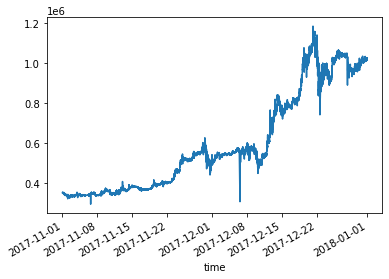

In [3]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

## 2. Data Labeling
① 데이터 라벨링
- 추세(Trend)를 Labeling하는 4가지 방법

추세를 Labeling하는 방식으로는 여러 방법이 있을 수 있으나, 여기서는 몇 가지 예시를 같이 보겠습니다.

* Price Change Direction
* Using Moving Average
* Local Min-Max
* Trend Scanning


### Price Change Direction
가장 단순한 방식으로 현재 가격과 특정 영업일 이전의 가격의 차이로 Labeling 하는 방식입니다. 

간단히 Labeling할 수 있으나, 며칠 전 가격과 비교할 것인지에 따라 변동이 커질 수 있어, 세심한 주의가 필요합니다.

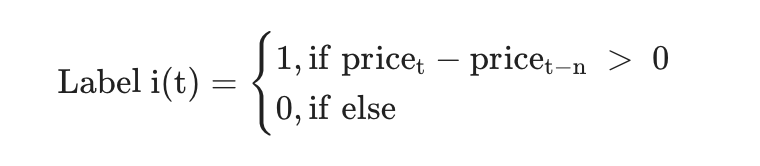

In [5]:
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

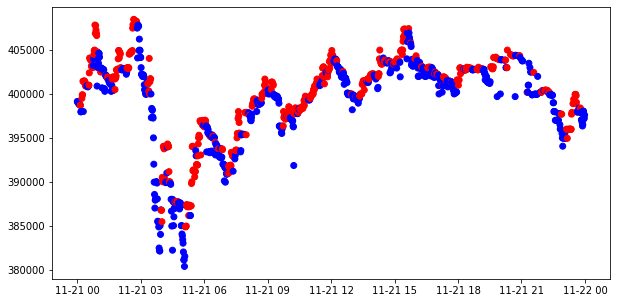

In [8]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### Using Moving Average

기술적 지표를 이용하여 Labeling하는 방식은 여러 가지가 있으나, 여기에서는 이동평균선을 이용한 방식만 간략히 소개하고 넘어가겠습니다. 

현재의 주가가 특정 이동평균선 위에 있는지, 아래에 있는지 여부로 Labeling을 하는 방식입니다. 

간단히 Labeling할 수 있으나, 가격 차이만으로 Labeling할 경우와 마찬가지로, 이동평균을 며칠로 할 것이냐를 결정하여야 하고, 이동평균으로 인해 Lag(지연)가 발생하게 됩니다.

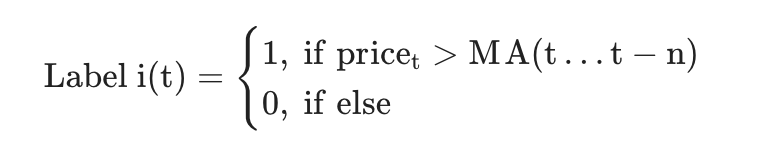

In [9]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

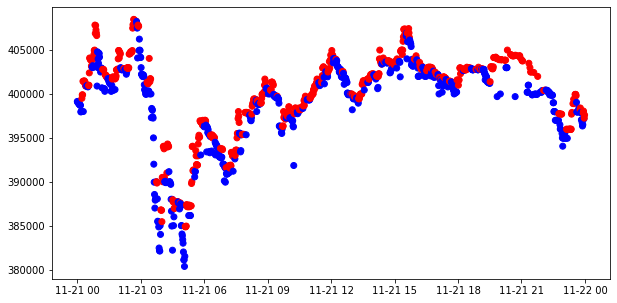

In [10]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### Local Min-Max

이 방식은 국지적인 최소 / 최대값을 계속 갱신하여, 최소-최대 구간을 이어나가며 Labeling하는 방식입니다.

여기서 소개하는 알고리즘만이 정답은 아니며, 국지적 최소 최대를 갱신할 수 있는 여러 방법이 있을 수 있습니다.

현 알고리즘은 계속해서 최소, 최대값을 갱신하다가, 서로 상대방값으로 초기화해 주는 것이 핵심입니다.

예를 들어, 현재 하락구간이어서 최소값이 계속 갱신되고 있다고 가정해 봅시다.

이전 최대값은 3,000원이고, 직전까지 최소값은 2,800원인데, 현재가격이 2,750원으로 더 낮아졌다면, 최소값이 갱신됩니다.

이어서, 다음 가격이 2,800원으로 상승을 시작했다면, 현재 하락구간은 종료되었다는 가정하에 최소값 갱신을 멈추고

이전 최대값을 현재 최소값인 2,750원으로 변경해 주어 앞으로 상승구간에서 최대값 갱신이 가능하도록 조정합니다.

여기서, 현재가격이 한번 상승했다고 바로 하락구간 종료를 가정하면, 빈번한 Labeling의 변화가 있을 수 있으므로, 좀 더 변동이 적은 작업을 위해 Wait 계수를 설정할 수 있습니다.

상승구간에서의 과정도 하락구간과 동일합니다.

이 방식은 순차적인 가격 확인이 요구되는 만큼 데이터가 증가하면, 선형적으로 연산시간도 늘어나는 단점이 있습니다.

또한, 앞선 방식들과 마찬가지로 Wait 계수를 작게하면 변동성이 커질 수 있으므로, 신중한 계수선택이 요구됩니다.

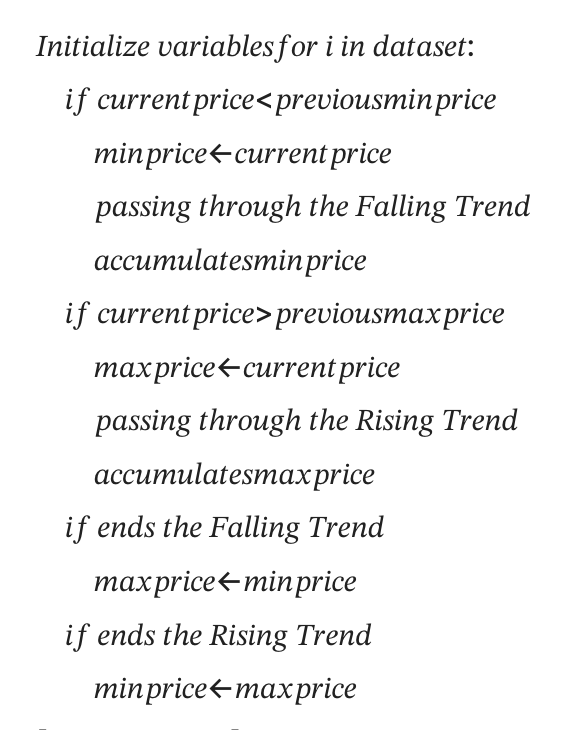

In [11]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [12]:
mins, maxes = get_local_min_max(sub_data, wait=3)

(376546.5, 412585.0)

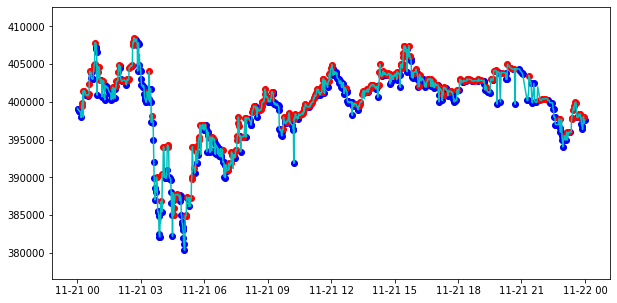

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

(376546.5, 412585.0)

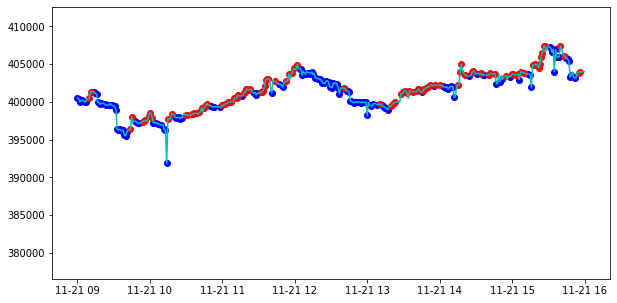

In [15]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

In [16]:
mins.shape[0], maxes.shape[0]

(477, 273)

### Trend Scanning
* Trend Scanning은 Marcos Lopez de Prado 의 저서 'Machine Learning for Asset Managers'에 소개된 Labeling 방식입니다.

* 시계열 데이터 𝑥𝑡가 주식 또는 코인의 가격이라고 가정해 봅시다.

    * 현재 𝑡 시점에서 𝑡+𝑙 시점까지의 회귀식을 Fitting하여, 𝛽 값을 구합니다.

    * 이 𝛽 값의 𝑡𝑣𝑎𝑙𝑢𝑒 를 구합니다.

    * max𝑡𝑣𝑎𝑙𝑢𝑒 의 부호를 통해 Labeling을 진행합니다.

* Tvalue란?
    두 대상이 평균적으로 얼마나 차이가 나는가를 표현한 정도를 나타낼 수 있습니다. 

    t-value 값이 클수록 두 대상의 평균의 차이는 크다고 할 수 있습니다. 

    t-value는 두 대상을 '평균적'으로 비교하고 싶을 때 사용합니다. 
    
    예시로 내가 세운 가설로 계산한 주가와 실제 주가는 평균적으로 큰 차이가 있을까?

    가설로 구한 주가와 실제 주가의 t-value가 0에서 멀다면 --> 가설로 구한 주가와 실제 주가는 차이가 크다고 비교해 볼 수 있습니다.
    
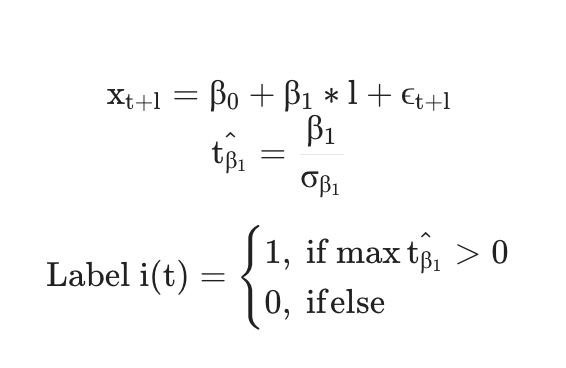

* 하기 코드는 Hudson & Thames 가 공개한 MLFinLab 패키지의 코드를 활용했습니다. Git MLFinLab





In [17]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [18]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [ ]:
# 이 코드 블럭은 실행에 20~30분정도 걸립니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

In [ ]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

## Feature Engineering
Feature Engineering이란 도메인 지식을 활용하여 정제되지 않은 원본 자료(raw data)를 탐색과 분석, 가공을 거쳐 특성추출 및 특성선택 하는 것을 말합니다.

① 환경구성 및 데이터 불러오기
- 필요 패키지 설치
- 데이터 불러오기

② Technical Index
- 기존 데이터셋(시가, 고가, 저가, 종가, 거래량)에서 기술적 지표(추세, 변동성, 거래량, 모멘텀)를 적용한 데이터셋 만들기
- 새로 만든 데이터셋에서 활용하고자 하는 시점에 대한 수익률, 변화율, 변동성을 적용

③ Feature Selection methods
- 특성추출(Feature Extraction)과 특성선택(Feature Selection) 중 특성선택을 하는 방법으로 접근하여 어떤 방법론이 있는지 확인해봅시다.


* Feature Selection
* Sequential Feature Selection
* Shapley Additive explanations


분류기의 설명력을 높이고, 성능을 개선하기 위해서 가장 중요한 것은 적절한 Feature를 선택하는 것입니다.

Feature를 선택하는 방식에는 여러 가지 방식이 있으며, 다음 세가지로 크게 분류할 수 있습니다.

* Filter Method: Feature들간의 연관성을 찾는 방식(information gain, correlation coefficient 등)

* Wrapper Method: 해결하고자 하는 문제에 대한 유용성을 측정하는 방식. Validation set에서의 성능이 최대화되는 Feature Set을 선정 (Recursive Feature Elimination, Sequential Feature Selection 등)

* Embedded Method: 훈련의 알고리즘에 Feature 선정과정이 포함되는 방식(Lasso, Ridge, Elastic Net 등)

이 중 Wrapper Method 몇 가지에 대한 사용방법을 알아보고, 이 외에 Prodo 의 저서 'Advances in Financial ML'에서 소개된 방식에 대해 알아보겠습니다.

또한, 주가 모멘텀 포착을 위해 사용할 수 있는 Feature들에는 무엇이 있는지 알아보고, 그 Feature 들 중 어떤 Feature를 선정해야 하는지 여러 방식으로 분석해 보도록 하겠습니다.

마지막으로 'SHAP'이라는 Feature 분석 패키지를 통해 Feature의 중요도를 확인해 보도록 하겠습니다.

## 1. 환경구성 및 데이터 불러오기
① 환경구성
- ta, shap 패키지 설치 및 필요 패키지 불러오기

② 데이터 불러오기
- Feature Engineering을 적용할 데이터셋 불러오기

<더 알아보기>
libs 설명

libs 내부에는 feature_engineering, feature_importance, mlutil 등의 파일로 구성되어있으며 이 과정에서 필요한 코드를 작성하여 보관하였습니다.
ta 설명

Python Pandas 기반의 금융 시계열 데이터 분석을 지원하는 라이브러리입니다.
자세한 내용은 ta 공식문서 를 참고하시기 바랍니다.

### ① 환경구성
ta, shap 패키지 설치 및 필요 패키지 불러오기

In [19]:
!pip install ta==0.9.0
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28907 sha256=d067b3a5a07e7a96f1308dbfa69d89f83670ad73ee2b672c08174d55578b1e40
  Stored in directory: /aiffel/.cache/pip/wheels/d1/3c/c4/176cfd752bd625c697799269715459e85c6dfd9500df26ad93
Successfully built ta
     |████████████████████████████████| 535 kB 5.7 MB/s            


In [20]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

### ② 데이터 불러오기
Feature Engineering을 적용할 데이터셋 불러오기

데이터셋을 불러오는 과정에 있는 Pickle(.pkl)은 Python의 list, class, dictionary와 같은 자료형(type)을 바이너리로 변환하여 파일로 저장된 것을 말합니다. 일반적으로 파일은 텍스트로 저장되며 파이썬의 자료형은 객체로 저장되는데 객체 상태로는 바로 사용할 수 없기 때문에 컴퓨터가 이해할 수 있는 바이너리로 저장되어 사용할 수 있습니다.

In [21]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

In [22]:
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [23]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [24]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [25]:
df_label_data.value_counts()

-1.0    306636
-0.0    302963
 1.0    299289
Name: t_value, dtype: int64

## 2. Technical Index
① 기술적 지표
- 아래 여러 지표들을 기존의 데이터셋에 추가하는 과정

② 수익률 / 변동성 지표
- 여러 지표들이 추가된 데이터셋에서 활용하고자 하는 시점에 수익률과 변동성 적용

수익률 / 변동성까지 적용된 데이터셋을 표준화(standardization)하고 fit_transform하여 RandomForest에 적용합니다. 아래 Feature Selection을 하기 위한 선행과정입니다.

### ① 기술적 지표
* 기술적 지표란?

시장의 주가 또는 거래량 데이터를 기반으로 주가의 향방을 예측하기 위해 고안된 지표입니다.

* 추세 지표

    * MACD, Moving Average Convergence/Divergence : 단기 이평선과 장기 이평선의 차이로 주가의 수렴 / 확산 정도를 나타내는 지표, 'signal', 'average', 'diverence'로 구성됨.
    * ADX, Average Directional Movement : 금일의 주가 움직임의 범위가 전일의 범위를 어느 방향으로 벗어났는지를 관찰, 추세의 강도를 추적하는 지표
    * TRIX, Triple Exponential : n-영업일 지수가중평균을 3번 연달아 실시한 후, 그 값의 기울기를 나타낸 지표
    * DPO, detrended price oscillator : 가장 최신의 가격 흐름에 반응하지 않도록 변위된 이동평균을 사용하여, 장기추세를 제거하기 위한 지표. 중기 과매수 / 과매도 정도를 표시
    * AROON, AROON : 추세의 강도와 변화를 식별하기 위한 지표, 고가사이의 시간차와 저가사이의 시간차를 측정
    
    
    
* 변동성 지표
    * ATR, Average True Range : 시장의 변동성을 측정하기 위한 지표, (고가 - 저가), (고가 - 전일종가)의 절대값, (저가 - 전일종가)의 절대값 중 큰값을 취하여, 이동평균
    * UI, Ulcer Index : 가격 하락의 유지기간, 깊이를 통해 가격의 하락 위험을 측정하는 지표
    
    
* 거래량 지표
    * CMF, Chaikin Money Flow : 산출방식이 MACD와 유사, 두 accumulation/distribution line의 EMA값의 차이를 통해 돈의 유입/유출을 파악하려는 지표
    * MFI, Money Flow Index : 가격의 흐름과 거래량의 조합으로 모멘텀의 방향성을 나타내는 지표
    * FI, Force Index : 가격과 거래량을 사용하여 가격의 움직임을 좌우하는 힘의 강도를 측정하는 지표
    * SMA EM, Ease of Movement : 가격의 상승/하락을 판단하기 위한 지표. 가격의 변동성과 거래량을 통해 가격 흐름의 용이성을 측정
    * VPT, Volume Price Trend : 가격의 변화 강도와 그 방향을 나타내는 지표. 수요 / 공급의 균형을 측정
    
* 모멘텀 지표
    * RSI, Relative Strength Index : 가격 흐름의 상대강도를 측정하는 지표. 일정기간 내의 평균 수익과 손실의 강도를 비교함.
    * WR, Williams %R : 과매도 / 과매수를 측정하는 지표(-100 ~ 0). 진입 / 청산 시점을 포착하는데 사용됨.
    
    
    
Python의 TA 패키지를 이용하여 각 지표를 산출할 수 있습니다.(ta 공식 문서 참고)






In [26]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [27]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


### ② 수익률 / 변동성 지표
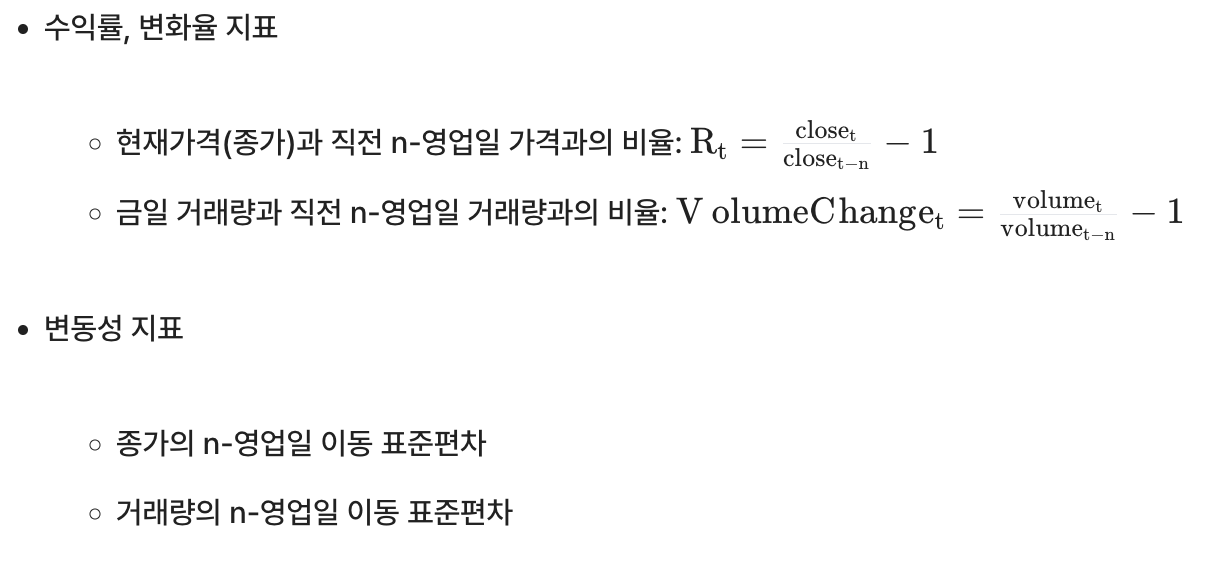

In [28]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [29]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [30]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [31]:
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671


In [32]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## 3. Feature Selection methods
특성선택(Feature Selection)을 위한 기법으로 다음과 같은 방법이 있습니다.

① Feature Selection
- MDI
- MDA

② Sequential Feature Selection
- RFE CV
- SFS

③ Shapley Additive explanations
- SHAP

### ① Feature Selection
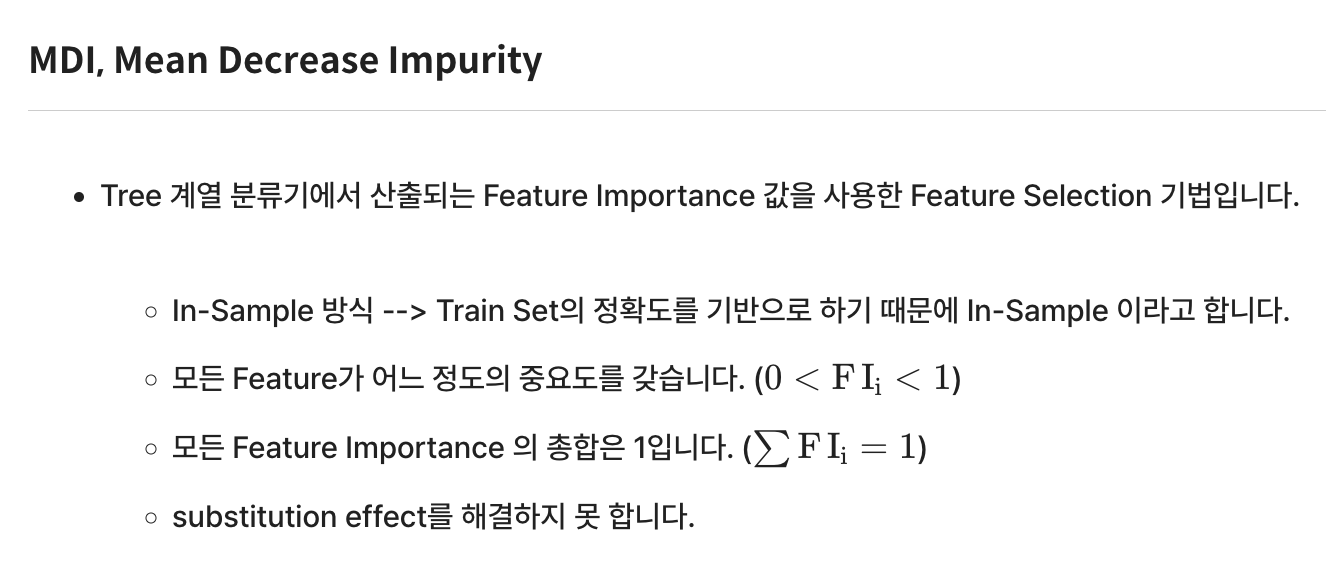

In [33]:
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)

In [34]:
feat_imp

,mean,std
volume_cmf,0.049851,0.002115
volume_fi,0.043992,0.002335
volume_mfi,0.049107,0.002638
volume_sma_em,0.037528,0.001663
volume_vpt,0.025233,0.001527
volatility_atr,0.077669,0.003203
volatility_ui,0.050057,0.002497
trend_macd_diff,0.068473,0.003197
trend_adx,0.055301,0.002432
trend_trix,0.069035,0.003008


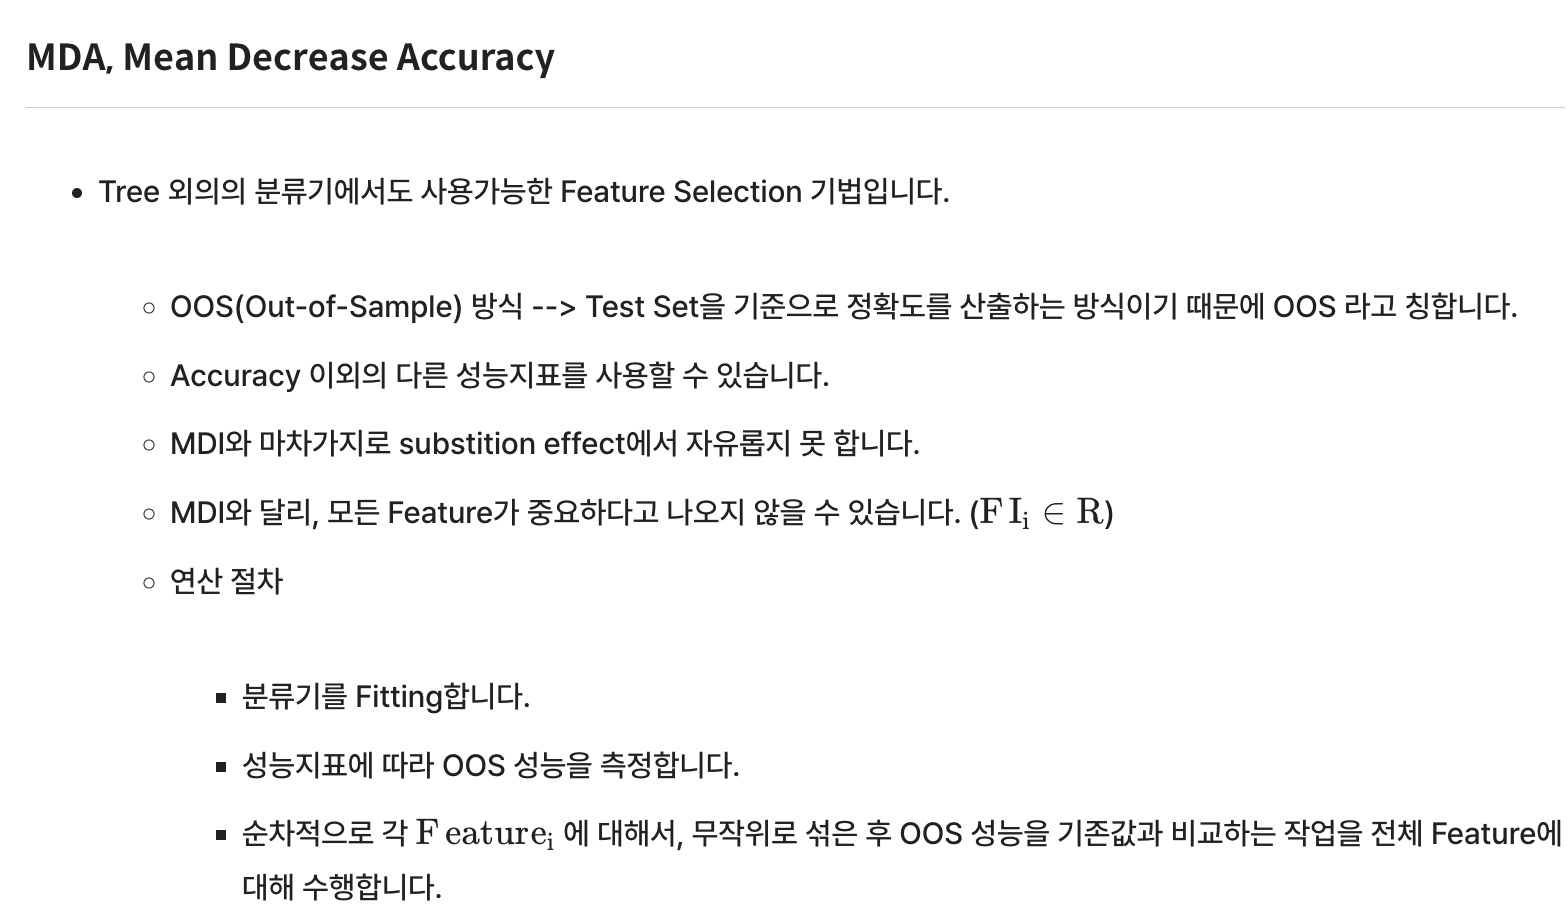

In [35]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [36]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

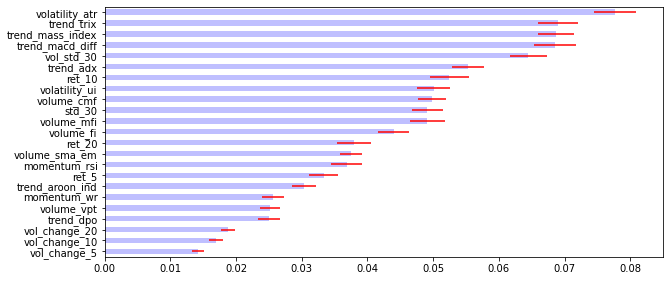

In [37]:
plot_feature_importance(feat_imp)

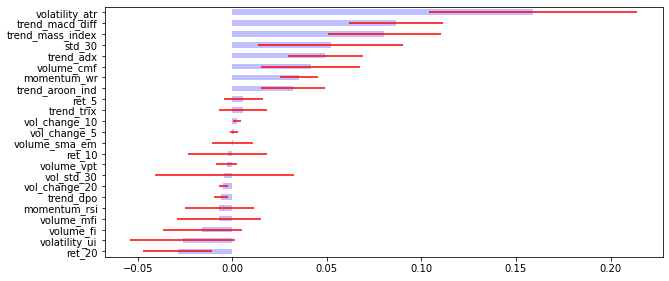

In [38]:
plot_feature_importance(feat_imp_mda)

### ② Sequential Feature Selection

#### RFE CV, Recursive Feature Elimination

* RFE방식에 CV를 도입한 기법입니다.

    * Data Set을 K개로 분할하여 학습과 검증을 동시에 진행하며, 검증시 Feature의 기여도에 따라 삭제 여부를 결정하는 방식을 말합니다.
    * Validation 성능이 가장 좋은 Feature를 최종 Feature로 결정합니다.





In [39]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

#### SFS, Sequential Feature Selection
* 순차적으로 Feature를 더하거나 빼는 방식으로 Feature의 최적조합을 찾는 방식입니다.
    * Backward / Forward 방식 모두 사용할 수 있습니다.
        * Forward: Null에서 시작하여, Feature를 하나씩 더해가는 방식으로 조합을 찾습니다.
        * Backwrd: 모든 Feature에서 시작하여 하나씩 빼가는 방식으로 조합을 찾습니다.

In [40]:
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=2, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

### ③ SHAP, Shapley Additive explanations
게임이론적인 접근방식을 통해 분류기의 출력을 설명하기 위한 기법입니다.

* 게임이론으로부터 Shapley Value를 추산하여, 이를 바탕으로 Feature를 설명합니다.
    * Shapley Value란?
        게임이론에서 여러명의 플레이어에게 공정한 상벌을 배분하기 위한 솔루션으로써, 여러 플레이어의 공헌도는 서로 상이하지만, 상호간에 이득과 손실을 주고받는 상황에 적용되는 값입니다.
        
        게임 내에서 각 플레이어는 최대의 성과를 얻어내기 위한 의사결정을 연쇄적으로 수행하게 되며 그러한 과정을 통해 얻게 된 게임의 결과에서 해당 플레이어에게 기대할 수 있는 평균적인 한계 공헌도를 Shpely Value라고 합니다.
        
게임이론에 대한 내용은 본 과정을 넘어서는 것이므로, 여기까지 소개하겠습니다.





In [41]:
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

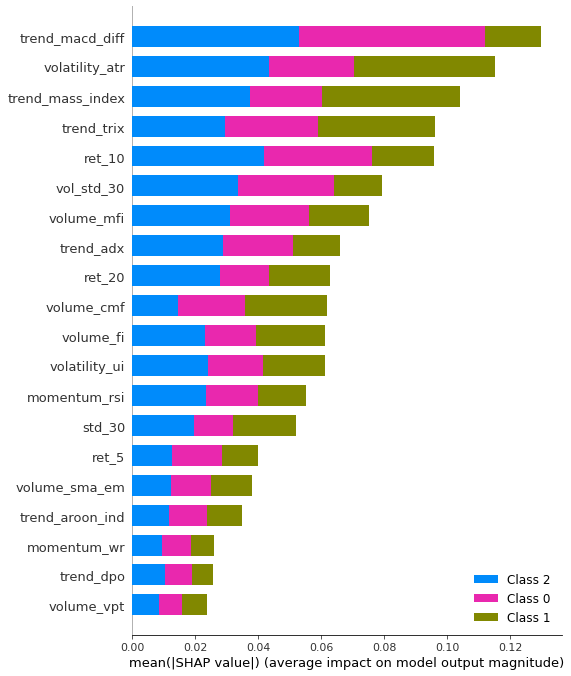

In [42]:
shap.summary_plot(shap_value, X_sc)

In [43]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)

## Model Training
PKFold 및 Model Traning을 하는 방법에 대해서 알아봅시다.

① 환경 구성
- 라이브러리 불러오기
- 데이터 불러오기

② Purged K-fold for Cross-Validation
- 기존의 Cross-Validation의 취약점인 Overfitting을 보완하기 위한 PKFold Cross Validation 사용

③ Find the best param for bagging(RandomForest) with grid-search
- 다음 순서로 학습 진행 (RandomForest -> Bagging -> GridSearchCV)
- Bagging은 RandomForest Classifier를 통해 생긴 오차의 분산을 줄이기 위해 사용
- GridSearchCV는 최적의 Parameter 값을 얻기 위해 사용

### 1. 환경구성 및 데이터 불러오기


In [44]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [45]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

In [46]:
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [47]:
df_data['t_value'].value_counts()

1.0    481
0.0    476
Name: t_value, dtype: int64

In [48]:
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

In [49]:
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [50]:
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000]
train_y = train_y[:1000]

### 2. Purged K-fold for Cross-Validation

Cross-Validation, 교차검증은 학습시 과적합을 막기 위한 하나의 방도로 데이터를 K개의 부분집합으로 나누어, K-1개의 부분집합으로 학습을 진행하고, 나머지 하나의 부분집합으로 검증을 진행하는 방식입니다.

여기서, 소개하는 Purged라는 개념은 학습데이터와 검증데이터를 나눌 때 두 시계열 사이의 연관성을 최대한 배제하기 위한 방법입니다.

일단, K-fold CV의 단점부터 알아보겠습니다.

    * 관측치들이 Independent & Identical Distirbuition, IID 상태에서 추출됐다고 가정하기 어렵습니다.
    * 테스트 집합 또한 모델 개발 과정에서 여러번 반복하여 사용되었을 가능성이 높습니다.
    * 이 과정에서 여러 Bias가 반영되었을 가능성이 농후합니다.

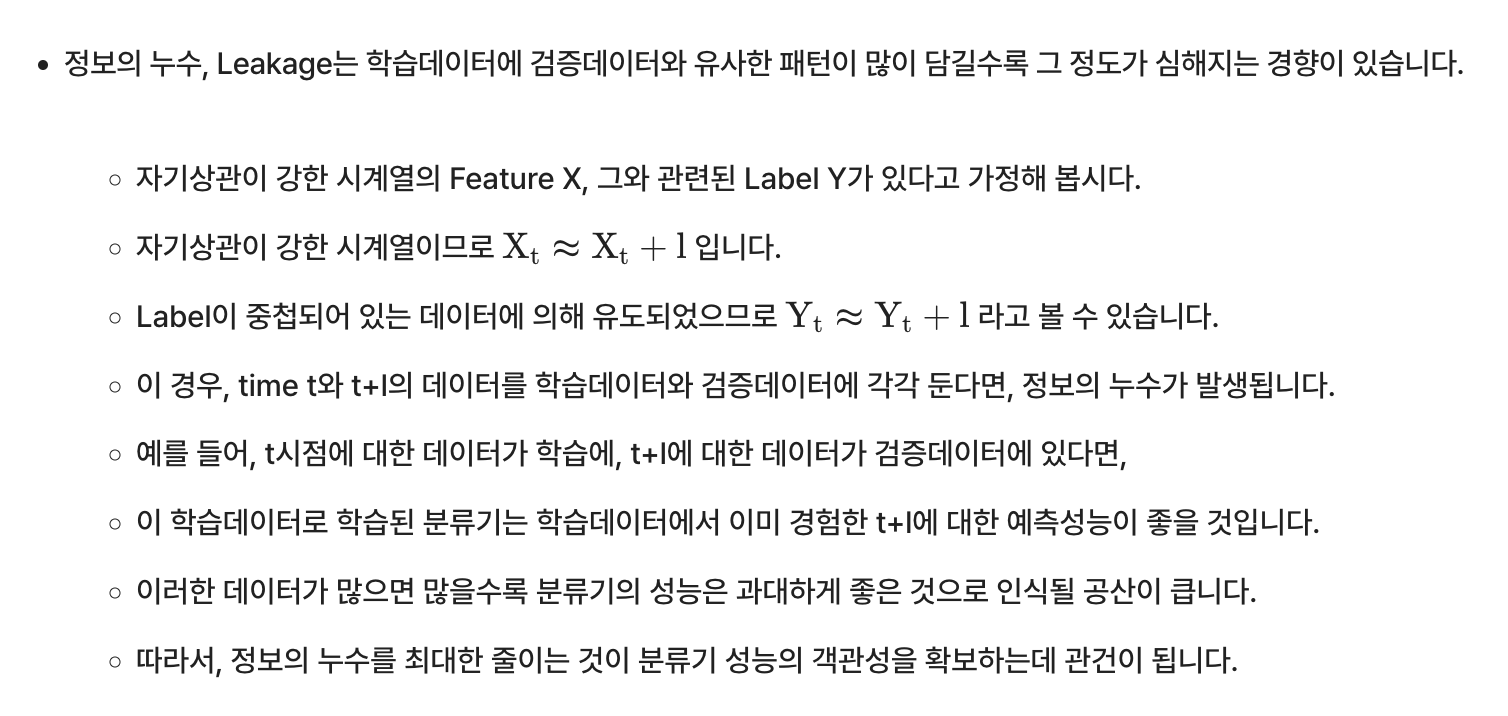

그렇다면, 어떻게 해야 이를 줄일 수 있을까요?

* 모든 관측값에 대해 학습데이터와 검증데이터가 서로 최대한 상관되지 않도록 시계열 집합간 일종의 시간차를 둡니다.
* 분류기의 Overfitting을 막기 위한 방안을 사용합니다. (Early Stopping, Regulization 등)
* 여기서, 시계열 집합간 일종의 시간차를 두는 것을 Purged 라고 합니다.


여기서는 PKFold 클래스를 통해 이를 구현합니다.

In [51]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

### 3. Find the best param for bagging(RandomForest) with grid-search
* ROC 곡선은 다양한 임계값에서 모델의 분류 성능에 대한 측정 그래프이며 좋은 성능의 분류 모델은 AUC 값이 1에 가까워집니다. 반대로 성능이 좋지 못한 분류 모델의 경우 0에 가까워집니다. 이 말의 뜻은 분류를 정확히 하지 못하는 경우를 말합니다.

    * ROC, Receiver Operating Characteristic : 그래프에서 곡선으로 휘어지거나 계단형태로 나타나는 부분
    * AUC, Area Under the Curve : 그래프에서 곡선 혹은 계단형태 아래에 해당하는 영역

* RandomForest를 기반으로 분류기(Classifier)를 학습시켜 보도록 하겠습니다.

    * 분류기의 최적 Hyper Parameter를 찾기 위해 일단, GridSearchCV에 들어갈 값의 Parameter를 지정하고, RandomForest를 먼저 학습시킵니다.
    * RandomForest를 학습하고 나온 결과값을 Bagging을 통해 학습하며 이는 오차의 분산을 줄이기 위해 사용합니다.
    * 이어서 앞서 GridSearchCV를 수행하기 위해 지정한 Parameter인 bc_params을 사용하고 GridSearch 클래스를 사용하여, fitting 합니다.
    * 이렇게 찾아진, best_estimator_ 값을 기반으로 만든 분류기(Classitier)를 통해 얼마나 분류가 잘되었는지 확인합니다.
    
* 잠시 분류기의 검증 오차에 대해서 간략히 설명하고 넘어가겠습니다.

    * 분류기를 통해 예측을 하려면 어쩔 수 없이 오차를 감수해야만 합니다. 얼마만큼 오차를 줄일 수 있느냐가 관건이겠죠.
    * 우리는 오차의 평균이 최대한 '0'에 가깝도록 분산도 작게 가져가길 바랍니다. 실제값과 예측값이 최대한 같길 바란다는 뜻입니다.
    * 여기서, 오차의 평균이 '0' 이 아니면, Bias, 편향되었다고 표현합니다.
    * 그래서, unbiased estimate, 불편추정량이라는 것은 내가 예측하고자 하는 실제값과 오차가 '0'인 값이란 뜻입니다.

    그러면, 과대적합, 과소적합을 이런 개념에서 정의해 보겠습니다.
    * underfitting, 과소적합: 오차의 평균이 Bias 되었으며, 분산이 작습니다.
    * overfitting, 과대적합: 오차의 평균도 작게 Bias 되었으며, 분산도 큽니다.
    
* 여기서, RandomForest를 Bagging으로 넘겨 학습을 진행하였습니다.

    * Bagging은 Bootstrap aggregating 에 약자로 분류기의 예측 오차의 분산을 감소시키기 위한 방법입니다.
    * Bootstrap은 데이터의 복원을 허용한 랜덤 표본 추출을 뜻하며, 이렇게 추출된 표본 데이터를 바탕으로 분류기를 병렬로 학습시키는 것을 Bagging이라고 합니다.
    * 이와 달리 Boosting에서는 잘못 예측한 데이터에 가중치를 두어 순차적으로 분류기를 학습시키게 됩니다.


위에서 이야기한 오차의 분산을 획기적으로 줄이기 위하여 Bagging을 사용합니다.






In [52]:
# 20분 소요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }
             
rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


In [53]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=3,
                                                        max_features=None,
                                                        min_samples_leaf=10),
                  bootstrap_features=True, max_features=0.7)

In [54]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [55]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[90 46]
 [13 42]]
정확도:0.6910994764397905, 정밀도:0.4772727272727273, 재현율:0.7636363636363637


auc:0.7127005347593582


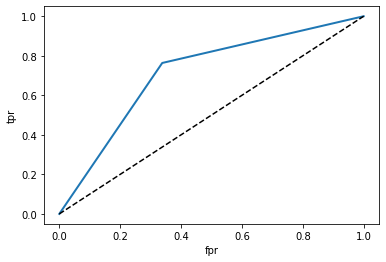

In [56]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')